### 1. Get some toy dtrajs to work with

Goal here is just to get some different-looking MFPT matrices to play with.

In [25]:
from msmbuilder.example_datasets import MetEnkephalin
trajs = MetEnkephalin().get().trajectories
#from msmbuilder.featurizer import DihedralFeaturizer
#dih = DihedralFeaturizer().fit_transform(trajs)
import pyemma


In [35]:
feat = pyemma.coordinates.featurizer(trajs[0].top)
pairs = []
for i in range(trajs[0].n_atoms)[::2]:
    for j in range(i)[::2]:
        pairs.append((i,j))
feat.add_distances(pairs)
feat.add_backbone_torsions(cossin=True)
len(feat.describe())

719

In [36]:
X = [feat.transform(traj) for traj in trajs]

In [37]:
from pyemma.coordinates import cluster_mini_batch_kmeans

tica = pyemma.coordinates.tica(X)
X_tica = tica.get_output()
X_tica[0].shape

(9979, 182)

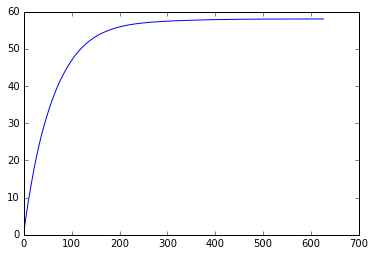

In [38]:
plt.plot(np.cumsum(tica.eigenvalues**2))

In [82]:
kmeans = cluster_mini_batch_kmeans(X_tica,k=500,max_iter=100)
dtrajs = kmeans.get_output()
dtrajs_met = [dtraj.flatten() for dtraj in dtrajs]

21-07-16 14:47:40 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[16] INFO     Algorithm did not reach convergence criterion of 1e-05 in 100 iterations. Consider increasing max_iter.


In [4]:
from msmbuilder.example_datasets import AlanineDipeptide
trajs = AlanineDipeptide().get().trajectories
dih = DihedralFeaturizer().fit_transform(trajs)
tica = pyemma.coordinates.tica(dih,dim=4)
X = tica.get_output()
kmeans = cluster_mini_batch_kmeans(X,k=200,max_iter=1000)
dtrajs = kmeans.get_output()
dtrajs_ala = [dtraj.flatten() for dtraj in dtrajs]

21-07-16 11:22:17 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3] INFO     Algorithm did not reach convergence criterion of 1e-05 in 100 iterations. Consider increasing max_iter.


### 2. Compute MFPT matrices

In [5]:
import pyemma

In [83]:
msm = pyemma.msm.estimate_markov_model(dtrajs_met,10)
msm.active_count_fraction

1.0

In [84]:
n = msm.nstates

In [85]:
import numpy as np
        
def _slow_mfpt_matrix(self):
    '''
    Compute the mean first-passage time matrix from a pyemma.MSM object,
    by making nstates^2 calls to `self.mfpt`.
    
    For testing purposes.
    
        
    Returns
    -------
    mfpt : (nstates,nstates), numpy.ndarray
        mfpt[i,j] = self.mfpt(i,j)
    '''
    n = self.nstates
    mfpt = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            mfpt[i,j] = self.mfpt(i,j)
    return mfpt
        
def mfpt_matrix(self):
    """
    Compute the mean first-passage time matrix from a pyemma.MSM object,
    using the generalized inverse.
    
    
    Parameters
    ----------
    msm : :obj:`PyEmma.MSM`
        the MSM object to be analyzed
        
    
    """
    tm = self.P
    size = self.nstates

    eq = self.stationary_distribution

    im = np.identity(size)
    wm = np.tile(eq, (size, 1))

    # A = 1 - P

    ahash =  np.linalg.inv(im - (tm - wm)) - wm
    adg = np.diag(np.diagonal(ahash))

    dm = np.diag(1.0 / eq)
    jm = np.ones((size,size))
    mm = (np.dot(im - ahash + np.dot(jm, adg), dm))

    return mm - np.diag(np.diag(mm))

mfpt_gi = mfpt_matrix(msm)
mfpt_slow = _slow_mfpt_matrix(msm)

In [55]:
mfpt = mfpt_slow

In [56]:
n=len(mfpt)

In [57]:
# is it a metric?

# D(x,y)>= 0, D(x,x)=0
print(np.min(mfpt)>=0)
print(np.trace(mfpt)==0)

# isolation?
# x=/=y implies D(x,y)>0
# if not, pseudometric: fix with equivalence classes
print(np.sum((mfpt-np.diag(np.diag(mfpt)))>0)==n**2-n)

# symmetry?
# D(x,y) = D(y,x)
# if not, quasimetric: fix with avg.: D_hat(x,y) = (D(x,y)+D(y,x))/2
print(np.sum(mfpt!=mfpt.T)==0)

# triangle inequality
# D(x,z) <= D(x,y)+D(y,z)
# if not, semimetric: metric completion: D(x,y) = shortest path
# or snowflake

triangle=True
for i in range(n):
    for j in range(n):
        for k in range(n):
            if mfpt[i,k] > mfpt[i,j] + mfpt[j,k]:
                triangle=False
print(triangle)

True
True
True
False
False


In [58]:
msm.nstates

200

In [59]:
msm.mfpt(0,0)

0.0

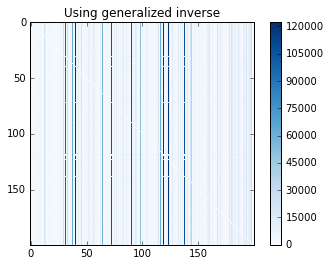

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(mfpt_gi,interpolation='none',cmap='Blues')
plt.colorbar()
plt.title('Using generalized inverse')

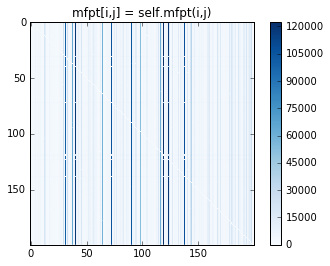

In [63]:
plt.title('mfpt[i,j] = self.mfpt(i,j)')
plt.imshow(mfpt_slow,interpolation='none',cmap='Blues')
plt.colorbar()

In [67]:
np.isclose(mfpt_slow,mfpt_gi)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [66]:
#np.diag(mfpt_gi),np.diag(mfpt_slow)

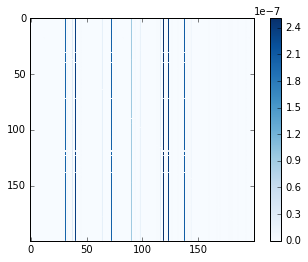

In [69]:
plt.imshow(mfpt_gi-mfpt_slow,interpolation='none',cmap='Blues')
plt.colorbar()

### 3. Recover metastable cores from the MFPT matrix

In [86]:
def local_mfpt_minima(mfpt_matrix,tau):
    ''' Definition suggested by JHP '''
    
    
    n = len(mfpt_matrix)
    
    close_neighbors = []
    fast_returning_close_neighbors = []
    
    for i in range(n):
        neighbor_list = []
        fr_neighbor_list = []
        for j in range(n):
            if mfpt_matrix[i,j]<tau and i!=j:
                neighbor_list.append(j)
                if mfpt_matrix[i,j]>mfpt_matrix[j,i]:
                    fr_neighbor_list.append(j)
            
        close_neighbors.append(neighbor_list)
        fast_returning_close_neighbors.append(fr_neighbor_list)
        
    core_states = [i for i in range(n) if \
                   set(close_neighbors[i])==set(fast_returning_close_neighbors[i]) \
                  and len(close_neighbors[i])>0]
    
    return close_neighbors,fast_returning_close_neighbors,core_states

In [93]:
close_neighbors,fast_returning_close_neighbors,core_states = \
    local_mfpt_minima(mfpt_gi,500)

In [94]:
len(mfpt_gi)

500

In [95]:
len(core_states)

2

In [101]:
n_core_states = []
taus = range(1,2000)
core_states_list = []

for i in taus:
    close_neighbors,fast_returning_close_neighbors,core_states = \
        local_mfpt_minima(mfpt_gi,i)
    core_states_list.append(core_states)
    n_core_states.append(len(core_states))

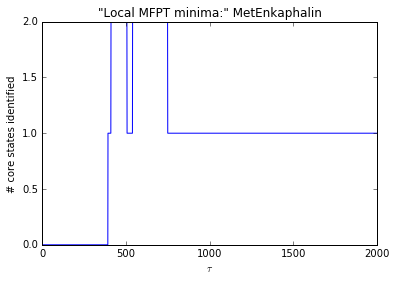

In [102]:
plt.plot(taus,n_core_states)
plt.xlabel(r'$\tau$')
plt.ylabel('# core states identified')
plt.title('"Local MFPT minima:" MetEnkaphalin')

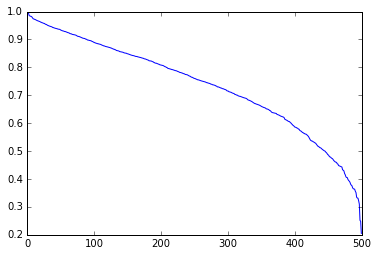

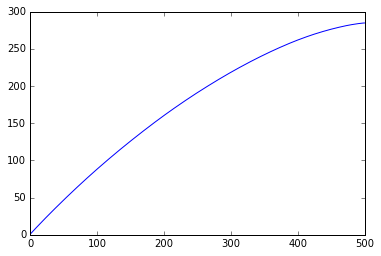

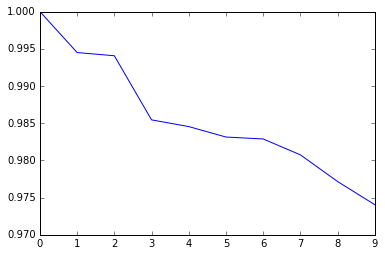

In [103]:
plt.plot(sorted(msm.eigenvalues())[::-1])
plt.figure()
plt.plot(np.cumsum(sorted(msm.eigenvalues()**2)[::-1]))
plt.figure()
plt.plot(sorted(msm.eigenvalues())[::-1][:10])

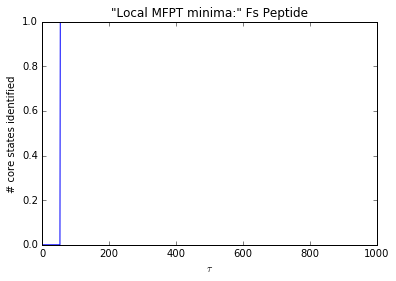

In [31]:
# do this again for fs peptide

msm = pyemma.msm.estimate_markov_model(dtrajs_fs,1)
mfpt_slow = _slow_mfpt_matrix(msm)
n_core_states = []
taus = range(1,1000)

for i in taus:
    close_neighbors,fast_returning_close_neighbors,core_states = \
        local_mfpt_minima(mfpt_slow,i)
    n_core_states.append(len(core_states))
plt.plot(taus,n_core_states)
plt.xlabel(r'$\tau$')
plt.ylabel('# core states identified')
plt.title('"Local MFPT minima:" Fs Peptide')

### 4. Playing around with the MFPT matrix

In [37]:
msm = pyemma.msm.estimate_markov_model(dtrajs_ala,1)
mfpt_slow = _slow_mfpt_matrix(msm)
m1 = mfpt_slow
eq = msm.stationary_distribution

In [38]:
difference = np.dot(np.diag(eq), m1) - np.dot(m1.T, np.diag(eq))

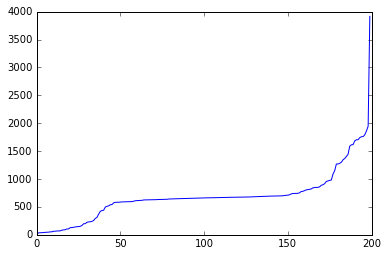

In [39]:
plt.plot(sorted(m1[0]))

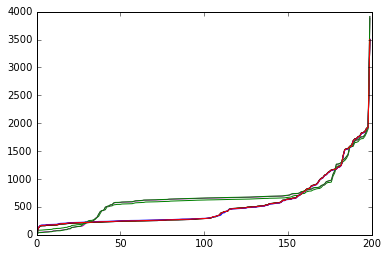

In [48]:
np.random.seed(0)
for i in range(10):
    ind = np.random.randint(0,len(m1))
    plt.plot(sorted(m1[ind]))

In [65]:
vals,vecs=np.linalg.eig(mfpt_slow)

(0, 200)

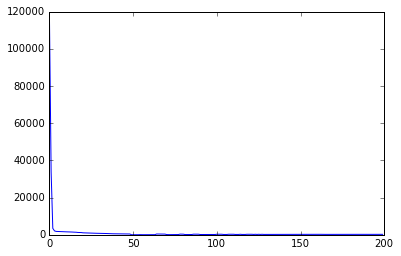

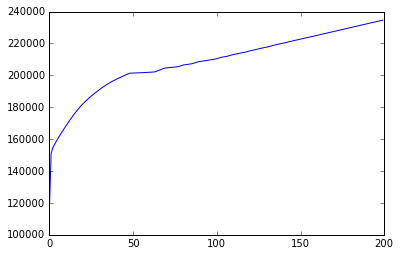

In [73]:
xmax = len(vals)
plt.plot(np.abs(vals))
plt.xlim(0,xmax)
plt.figure()
plt.plot(np.cumsum(np.abs(vals)))
plt.xlim(0,xmax)

In [49]:
m1.T.dot(np.diag(eq)) - np.diag(eq).dot(m1.T)

array([[ 0.        , -4.46297293, -1.37645701, ..., -4.99961584,
        -4.5882796 , -4.63482358],
       [ 5.68564442,  0.        , -1.49505223, ..., -0.24047821,
        -0.04699462, -0.06792541],
       [ 6.57752378,  2.28930146,  0.        , ...,  1.34030299,
         2.10922307,  2.02625385],
       ..., 
       [ 7.15630448,  0.32289879, -0.99207216, ...,  0.        ,
         0.25781411,  0.23005323],
       [ 6.01297622,  0.0508644 , -1.42327159, ..., -0.20743065,
         0.        , -0.02220722],
       [ 6.10570827,  0.07454124, -1.37503013, ..., -0.18771941,
         0.02252183,  0.        ]])

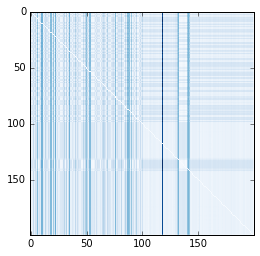

In [50]:
plt.imshow(m1,interpolation='none',cmap='Blues');

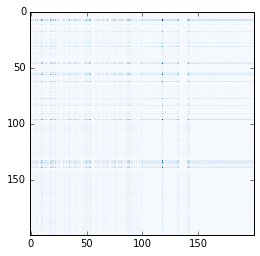

In [51]:
plt.imshow(np.dot(np.diag(eq), m1),interpolation='none',cmap='Blues');

[  5.63180197e+02   5.63180197e+02   7.25145644e+01   7.25145644e+01
   5.04878790e-01   5.04878790e-01   3.04192512e-01   3.04192512e-01
   1.10310197e-01   1.10310197e-01]


(0, 10)

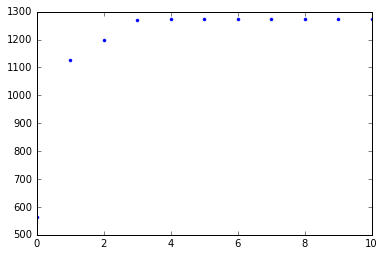

In [87]:
A = m1.T.dot(np.diag(eq)) - np.diag(eq).dot(m1.T)
vals,vecs=np.linalg.eig(A)
print(np.abs(vals)[:10])
plt.plot(np.cumsum(np.abs(vals)),'.')
plt.xlim(0,10)

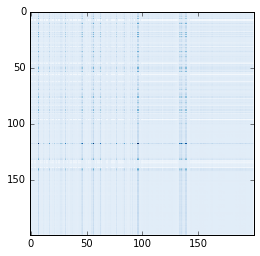

In [88]:
plt.imshow(A,interpolation='none',cmap='Blues');

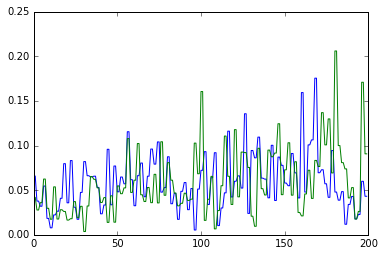

In [92]:
plt.plot(np.abs(vecs[0]))
plt.plot(np.abs(vecs[1]))


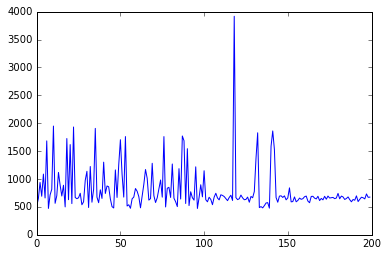

In [96]:
mfpt = mfpt_slow
plt.plot(mfpt.max(0))

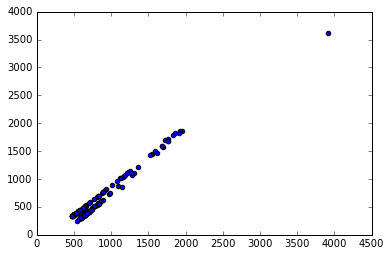

In [99]:
plt.scatter(mfpt.max(0),mfpt.mean(0))

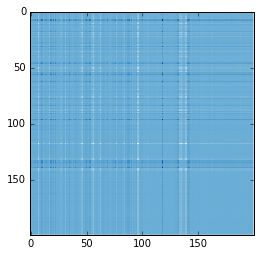

In [52]:
plt.imshow(difference,interpolation='none',cmap='Blues');

In [53]:
vals,vecs = np.linalg.eig(difference)

In [54]:
np.abs(vals).max()

1035.6024094397806

In [55]:
sorted(np.abs(vals))[::-1][:10]

[1035.6024094397806,
 1035.6024094397806,
 85.595588709084723,
 85.595588709084723,
 0.57082609012069796,
 0.57082609012069796,
 0.30077938545140476,
 0.30077938545140476,
 0.10363723490522934,
 0.10363723490522934]

### 4.1. Transition matrix analogy

In [56]:
T = msm.transition_matrix

In [57]:
difference = np.dot(np.diag(eq), T) - np.dot(T.T, np.diag(eq))

In [58]:
difference

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.35525272e-20,   1.35525272e-20,   2.71050543e-20],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,  -1.35525272e-20,   0.00000000e+00, ...,
          0.00000000e+00,  -3.38813179e-21,   6.77626358e-21],
       [  0.00000000e+00,  -1.35525272e-20,   0.00000000e+00, ...,
          3.38813179e-21,   0.00000000e+00,   3.38813179e-20],
       [  0.00000000e+00,  -2.71050543e-20,   0.00000000e+00, ...,
         -6.77626358e-21,  -3.38813179e-20,   0.00000000e+00]])

In [59]:
vals,vecs=np.linalg.eigh((T-T.T))
np.mean(np.abs(vals))

0.03839393616150124

In [60]:
vals,vecs=np.linalg.eigh(difference)
np.mean(np.abs(vals))

1.1868187688776277e-18

In [61]:
vals,vecs = np.linalg.eigh(mfpt_slow)

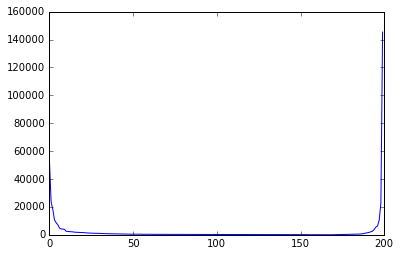

In [62]:
plt.plot(np.abs(vals))

In [63]:
vals,vecs = np.linalg.eigh(mfpt_slow)